In [1]:
!uv sync
import torch
import morphological_torch
import matplotlib.pyplot as plt
import timeit
from pytorch_semifield_conv import SelectSemifield, BroadcastSemifield
from pytorch_semifield_conv.utils import ConvMeta
from src import load_data
from functools import partial
import math
import numpy as np
import polars as pl

from tqdm.auto import tqdm, trange

Resolved 162 packages in 1ms
Prepared 2 packages in 137ms                                             
Uninstalled 2 packages in 0.66ms
Installed 2 packages in 0.58ms=0.1.0 (from file:///home/pete
 ~ pytorch-numba-extension-jit==0.1.0 (from file:///home/peter/Thesis/pytorch-numba-extension-jit)
 ~ pytorch-semifield-conv==0.1.0 (from file:///home/peter/Thesis/pytorch-semifield-conv)


In [2]:
test_data = load_data.k_mnist().x_train[:4096].repeat((1, 6, 1, 1)).cuda()
test_data.shape

torch.Size([4096, 6, 28, 28])

In [3]:
INF = float("inf")
test_kernels = -torch.asarray(
    [
        # 1: Does nothing
        [[[INF, INF, INF], [INF, 0, INF], [INF, INF, INF]]],
        # 2: Vertical max
        [[[INF, 0, INF], [INF, 0, INF], [INF, 0, INF]]],
        # 3: Horizontal max
        [[[INF, INF, INF], [0, 0, 0], [INF, INF, INF]]],
        # 4: 3x3 max
        [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]],
        # 5: small quadratic max, isotropic
        [[[0.4, 0.1, 0.4], [0.1, 0, 0.1], [0.4, 0.1, 0.4]]],
        # 6: small quadratic max, wide horizontally
        [[[0.5, 0.2, 0.5], [0.05, 0, 0.05], [0.5, 0.2, 0.5]]],
    ],
    device="cuda",
)
test_kernels.shape

torch.Size([6, 1, 3, 3])

In [4]:
unfold_dilate = BroadcastSemifield.tropical_max().module()

In [5]:
# noinspection PyUnusedLocal
def rick_dilate(
        imgs, kernel, padding=None, stride=2, dilation=None, groups=None, kind=None
):
    return morphological_torch.pooling_autograd.ParameterizedMaxPool2DAutogradFunction.apply(
        imgs, kernel.squeeze(1), stride, 0
    )[0]

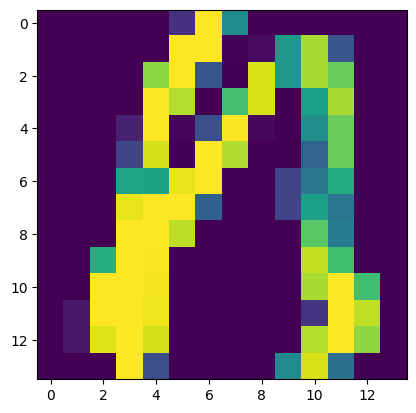

In [6]:
pool = morphological_torch.MaxPool2D(3)
plt.imshow(
    rick_dilate(test_data[:100], test_kernels.squeeze(1))[0][1].numpy(force=True)
)

In [7]:
test_grads_img = []
test_grads_kernel = []
for test_op in tqdm(
        (unfold_dilate, SelectSemifield.tropical_max().lazy_fixed(), rick_dilate)
):
    test_di = test_data[:4096].clone().requires_grad_(True)
    test_dk = test_kernels.clone().requires_grad_(True)
    test_op(
        test_di, test_dk, stride=2, padding=1, groups=6, kind="corr"
    ).sum().backward()
    test_grads_img.append(test_di.grad.clone())
    test_grads_kernel.append(test_dk.grad.clone())

  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
torch.testing.assert_close(test_grads_img[0], test_grads_img[1])
torch.testing.assert_close(test_grads_img[1], test_grads_img[2])
torch.testing.assert_close(test_grads_kernel[0], test_grads_kernel[1])
torch.testing.assert_close(test_grads_kernel[1], test_grads_kernel[2])

In [57]:
def get_timings_comparison(
        n_loops: int = 1_000,
        data: torch.Tensor = test_data,
        kernel: torch.Tensor = test_kernels,
        stride: int = 1,
        stop=23):
    padding = kernel.shape[2] // 2
    code = f"""
arr = dilate()
arr.backward(gradient)
sync() """

    def timer(glob):
        return (
                timeit.timeit(
                    code,
                    number=n_loops,
                    globals=glob,
                )
                / n_loops
        )

    kernel = kernel.clone().requires_grad_(True)
    meta = ConvMeta.infer(
        data, kernel, stride, padding, groups=data.shape[1], kind="corr"
    )
    numba_dilate = SelectSemifield.tropical_max().compile(meta, to_extension=False)
    numba_dilate(data[:4], kernel)

    ext_dilate = SelectSemifield.tropical_max().compile(meta, to_extension=True)
    ext_dilate(data[:4], kernel)

    sizes = []
    unfold_times = []
    numba_times = []
    ext_times = []
    rick_times = []

    bar = trange(2, stop)

    # Warmup
    warmup_fun = lambda: ext_dilate(data[:1024], kernel)[0]
    timer({"sync": torch.cuda.synchronize, 'dilate': warmup_fun, 'gradient': torch.rand_like(warmup_fun())})

    for log_size in bar:
        size = math.ceil(2 ** (log_size / 2))
        batch = data[:size].clone().requires_grad_(True)
        sizes.append(len(batch))
        bar.set_postfix(size=len(batch))

        gradient = torch.randn_like(ext_dilate(batch, kernel)[0])
        common_globals = {
            "sync": torch.cuda.synchronize,
            "gradient": gradient,
        }
        unfold_times.append(timer(common_globals | {
            "dilate": partial(unfold_dilate, batch, kernel, padding=padding, stride=stride, groups=data.shape[1],
                              kind="corr")}))
        numba_times.append(timer(common_globals | {
            "dilate": lambda: numba_dilate(batch, kernel)[0]}))
        ext_times.append(timer(common_globals | {
            "dilate": lambda: ext_dilate(batch, kernel)[0]}))
        rick_times.append(
            timer(
                common_globals
                | {
                    "dilate": lambda:
                    morphological_torch.pooling_autograd.ParameterizedMaxPool2DAutogradFunction.apply(
                        batch, kernel.squeeze(1),
                        stride, 0
                    )[0]
                }
            )
        )

    return sizes, unfold_times, numba_times, ext_times, rick_times

In [42]:
res = get_timings_comparison()

  0%|          | 0/21 [00:00<?, ?it/s]

In [53]:
pl.DataFrame(res, schema=['sizes', 'unfold_times', 'numba_times', 'ext_times', 'rick_times']).write_parquet(
    "./.data/timing_3_s1.pq")

In [43]:
def plot_timings_comparison(
        sizes, unfold_times, numba_times, extension_times, rick_times, title=""
):
    basic_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    plt.plot(sizes, unfold_times, label="Unfold", color=basic_colors[0])
    plt.scatter(sizes, unfold_times, color=basic_colors[0])
    plt.plot(sizes, numba_times, label="Numba CUDA", color=basic_colors[1])
    plt.scatter(sizes, numba_times, color=basic_colors[1])
    plt.plot(sizes, extension_times, label="PTX Extension", color=basic_colors[2])
    plt.scatter(sizes, extension_times, color=basic_colors[2])
    plt.plot(sizes, rick_times, label="Morphpool", color=basic_colors[3])
    plt.scatter(sizes, rick_times, color=basic_colors[3])
    plt.xlabel("Batch size")
    plt.ylabel("Time")
    plt.title(title)
    plt.loglog()
    plt.legend()
    plt.show()

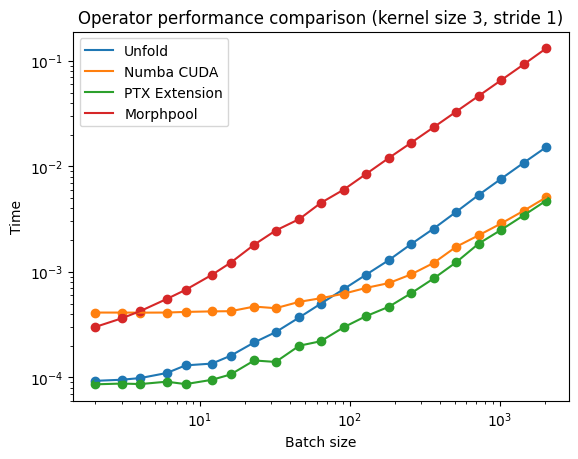

In [52]:
plot_timings_comparison(*res, title="Operator performance comparison (kernel size 3, stride 1)")

In [56]:
res_s2 = get_timings_comparison(stride=2)

  0%|          | 0/21 [00:00<?, ?it/s]

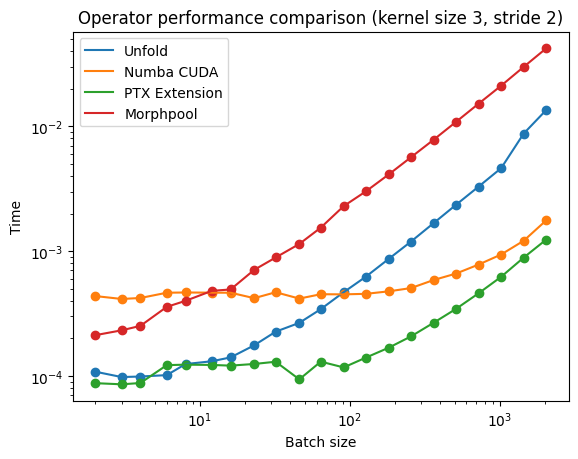

In [59]:
plot_timings_comparison(*res_s2, title="Operator performance comparison (kernel size 3, stride 2)")

In [60]:
test_kernels_7 = torch.randn((6, 1, 7, 7), device='cuda')
test_kernels_7.shape

torch.Size([6, 1, 7, 7])

In [63]:
res7_s2 = get_timings_comparison(kernel=test_kernels_7, stride=2)

  0%|          | 0/21 [00:00<?, ?it/s]

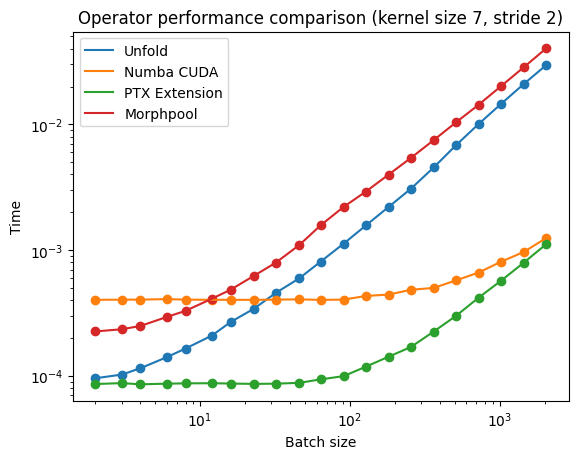

In [65]:
plot_timings_comparison(*res7_s2, title="Operator performance comparison (kernel size 7, stride 2)")